### Agent with Memory using MemorySaver

In [8]:
# importing libraries

import os
from dotenv import load_dotenv
load_dotenv()

from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_tavily import TavilySearch

from langchain.chat_models import init_chat_model

from typing_extensions import TypedDict
from typing import Annotated, List

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver

from pprint import pprint

In [2]:
#using tools provided by langchain

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=500))

arxiv = ArxivQueryRun(api_wrapper= ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=500))

tavily= TavilySearch(max_results=3)

tools=[wikipedia, arxiv, tavily]
tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\RAGs In Depth\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=500)),
 ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500)),
 TavilySearch(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))]

In [3]:
#tools binded chat model

tools_model = init_chat_model(model="groq:llama-3.1-8b-instant").bind_tools(tools)
tools_model


RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000002AE0C384310>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002AE0C4D1D10>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'query to look up on wikipedia', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'fu

In [4]:
#defining state schema for graph

class State(TypedDict):
    messages: Annotated[List, add_messages]


In [5]:
#node definition

def model_node(state:State):
    return {"messages": tools_model.invoke(state['messages'])}

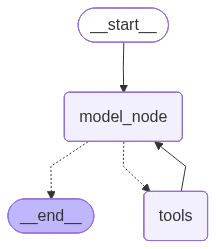

In [9]:
#graph workflow

graph = StateGraph(State)

graph.add_node("model_node", model_node)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "model_node")
graph.add_conditional_edges("model_node", tools_condition)
graph.add_edge("tools", "model_node")
graph.add_edge("model_node", END)

#memorysaver checkpointer

memory= MemorySaver()

graph_builder = graph.compile(checkpointer=memory)
graph_builder




In [11]:
query="give 3 latest ai news"
config = {"configurable": {"thread_id": 1}}

response = graph_builder.invoke({"messages": query}, config=config)
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

give 3 latest ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (gsj8r4zym)
 Call ID: gsj8r4zym
  Args:
    query: latest AI news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.foxnews.com/tech/ai-newsletter-blue-collar-productivity-boom", "title": "Fox News AI Newsletter: Blue-collar productivity boom - Fox News", "score": 0.769306, "published_date": "Fri, 19 Dec 2025 14:49:03 GMT", "content": "# Fox News AI Newsletter: Blue-collar productivity boom. ## **Welcome to Fox News’ Artificial Intelligence newsletter with the latest AI technology advancements.**. **RISE OF MACHINES:** Palantir Chief Technology Officer Shyam Sankar told FO

In [13]:
query="give one more news about same topic"
config = {"configurable": {"thread_id": 1}}

response = graph_builder.invoke({"messages": query}, config=config)
for message in response['messages']:
    message.pretty_print()

APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `llama-3.1-8b-instant` in organization `org_01k66286qyeesr19q9k4xxa0bg` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 8397, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}